## 1. Data Pre-processing

### 1.1 Load Data

In [12]:
!jupyter nbextension enable 

Please specify an nbextension/package to enable or disable


In [13]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import numpy as np
from fredapi import Fred
from tqdm import tqdm

API_KEY = '1vGb0FOsg2hEIGrEhpueLCcWd1Y'
FRED_API_KEY = 'b13a905b98b5dfc1f3910d6a0d875ae3'

rootUrl = 'https://api.glassnode.com'

symbolList = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL', 'BAND', 'BAT', 'BIX', 'BNT', 'BOND', 'BRD', 'BUSD', 'BZRX', 'CELR', 'CHSB', 'CND', 'COMP', 'CREAM', 'CRO', 'CRV', 'CVC', 'CVP', 'DAI', 'DDX', 'DENT', 'DGX', 'DHT', 'DMG', 'DODO', 'DOUGH', 'DRGN', 'ELF', 'ENG', 'ENJ', 'EURS', 'FET', 'FTT', 'FUN', 'GNO', 'GUSD', 'HEGIC', 'HOT', 'HPT', 'HT', 'HUSD', 'INDEX', 'KCS', 'LAMB', 'LBA', 'LDO', 'LEO', 'LINK', 'LOOM', 'LRC', 'MANA', 'MATIC',
              'MCB', 'MCO', 'MFT', 'MIR', 'MKR', 'MLN', 'MTA', 'MTL', 'MX', 'NDX', 'NEXO', 'NFTX', 'NMR', 'Nsure', 'OCEAN', 'OKB', 'OMG', 'PAY', 'PERP', 'PICKLE', 'PNK', 'PNT', 'POLY', 'POWR', 'PPT', 'QASH', 'QKC', 'QNT', 'RDN', 'REN', 'REP', 'RLC', 'ROOK', 'RPL', 'RSR', 'SAI', 'SAN', 'SNT', 'SNX', 'STAKE', 'STORJ', 'sUSD', 'SUSHI', 'TEL', 'TOP', 'UBT', 'UMA', 'UNI', 'USDC', 'USDK', 'USDP', 'USDT', 'UTK', 'VERI', 'WaBi', 'WAX', 'WBTC', 'WETH', 'wNXM', 'WTC', 'YAM', 'YFI', 'ZRX']

# symbolListShort = ['BTC', 'ETH', 'LTC']

endPoints = {
    'Price': '/v1/metrics/market/price_usd_close',
    'MarketCap': '/v1/metrics/market/marketcap_usd',
    'ActiveAddress': '/v1/metrics/addresses/active_count',
}

### 1.2 Get Multiple Attributes for Multiple Coins:

In [15]:
def PullData(coin: str,
             feature: str):
    """This Method Pull Data According to Input Parameters(coin, feature)

    Args:
        coin (str): Name of a Coin. Like: "BTC"
        feature (str): Feature of a Coin. Like: "Price"

    Returns:
        data (pd.DataFrame): A DataFrame Contains Date and Feature of One Coin
    """
    print(f"Pulling {coin}'s {feature}")

    import requests

    # Assemble full request url and get responses:
    reqUrl = rootUrl + endPoints[feature]
    res = requests.get(reqUrl,
                       params={'a': coin,
                               'api_key': API_KEY,
                               'i': '1w'})
    data_raw = pd.read_json(res.text,
                            convert_dates=['t'])

    # Rename column "v" according to features
    data = data_raw.rename(columns={"v": f"{feature}",
                                    't': 'Date'})

    # Return a dataframe
    return data

In [16]:
def PullStart(coinList: list):
    """This Method Gets Features(Listed in "endPoints"(Constant)) of Coins(Listed in "coinList"(Method Parameter))

    Args:
        coinList (list): The List of Coins' Name

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Contains All Features of Listed Coin's
    """
    # Initialization
    from functools import reduce
    from tqdm import tqdm
    from fredapi import Fred

    colName = ["Date"]
    for key in endPoints.items():
        colName.append(key)
    fullFrame = pd.DataFrame(columns=colName.append("Asset"))

    # Pull Fred RiskFree
    fred = Fred(api_key=FRED_API_KEY)
    Risk_free_rate = fred.get_series('DGS1MO', frequency = 'wem').to_frame().reset_index().rename(columns={'index': 'Date',
                                                                                        0: 'RiskFree'})
    Risk_free_rate['RiskFree'] = Risk_free_rate['RiskFree'] / 100

    # Data Pull
    for i in tqdm(coinList):
        print(f"\nStart Pulling {i}'s data:")

        # Preparation for merging
        frameName = f"{i}_Frames"
        locals()[frameName] = []

        # Get data
        for j in list(endPoints.keys()):
            locals()[frameName].append(PullData(i,
                                                j))

        # Merge 2-column dataframes to a single dataframe
        dfName = f"{i}_All"
        # Outer Merge Glassnode to Ensure Not Missing Any Values.
        # Left Merge Fred to ensure all the records in api stored.
        locals()[dfName] = reduce(lambda left, right:
                                  pd.merge(left, right,
                                           on='Date',
                                           how='outer'),
                                  locals()[frameName]).merge(Risk_free_rate,
                                                             how='left',
                                                             on='Date').sort_values(by=['Date'])
        locals()[dfName]['Asset'] = i

        # Merge All Coins into a single Dataframe
        fullFrame = pd.concat([fullFrame, locals()[dfName]],
                                     ignore_index=True)

        print(f"\n{i} data successfully pulled\n")
    print('All Frames Merged')
    print('\nALL DATA SUCCESSFULLY PULLED!')

    return fullFrame

### 1.3 Imputation for NA values using linear interpolation method

If the price for the asset is missing for the latest 4 weeks , then we consider it as a cryto currency that stopped trading, we won't include it in our sample. (this should be done before return calculation)

In [17]:
def InterpolationImpute (sample: pd.DataFrame):
    """This Method will impute NA values using linear interpolation method

    Args:
        sample (pd.DataFrame): The Pulled Data 

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Imputed all NA using linear interpolation
    """
    # Initialization
    imputedFrame = pd.DataFrame(columns=list(sample.columns))
    
    orgcols = list(sample.columns)
    cols = orgcols.copy()
    cols.remove('Date')
    cols.remove('Asset')
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)

#if the price for the asset is missing for the latest **4 weeks** , 
#then we consider it as a cryto currency that stopped trading, we won't include it in our sample

        if (segment['Price'][-4:].isnull().sum() < 4):
            temp = segment[cols].interpolate(method='linear', limit_direction='forward', axis=0)
            temp['Asset'] = segment['Asset']
            temp['Date'] = segment['Date']
            imputedFrame = pd.concat([imputedFrame, temp[orgcols]],
                                     ignore_index=True)
    

    
    return imputedFrame

### <font color = red> 1.4 Calculate Returns (to be changed)

In [18]:
def AddReturn(sample: pd.DataFrame):
    """This Method Add Return Column to Pulled Raw Data

    Args:
        sample (pd.DataFrame): The Raw Pulled Data without a Return Column

    Returns:
        fullFrame (pd.DataFrame): DataFrame with a Return Column
    """
    fullFrame = pd.DataFrame(columns=list(sample.columns).append(['Return','week2_return','Npast52']))
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)
        # Only Select 53 Weeks for Test
#         temp = segment[-53:-1].reset_index().drop('index', axis=1)
#         segment = segment[-52:].reset_index().drop('index', axis=1)
        segment = segment.assign(Return = segment.Price.rolling(2).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]).copy())
        segment = segment.assign(week2_return = segment.Price.rolling(3).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]))
        segment = segment.assign(Npast52_return = segment.Price.rolling(52).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]))
        segment = segment[-52:].reset_index(drop=True)
        fullFrame = pd.concat([fullFrame, segment],
                                     ignore_index=True)
        fullFrame["ExcessReturn"] = fullFrame["Return"] - fullFrame["RiskFree"]

    return fullFrame

### 1.5 Initialize 

In [19]:
# Get fullSample Raw Data(Without Return)
fullSample_raw = PullStart(symbolList)

  0%|                                                   | 0/124 [00:00<?, ?it/s]


Start Pulling BTC's data:
Pulling BTC's Price
Pulling BTC's MarketCap
Pulling BTC's ActiveAddress


  1%|▎                                          | 1/124 [00:03<07:47,  3.80s/it]


BTC data successfully pulled


Start Pulling ETH's data:
Pulling ETH's Price
Pulling ETH's MarketCap
Pulling ETH's ActiveAddress


  2%|▋                                          | 2/124 [00:05<05:09,  2.54s/it]


ETH data successfully pulled


Start Pulling LTC's data:
Pulling LTC's Price
Pulling LTC's MarketCap
Pulling LTC's ActiveAddress


  2%|█                                          | 3/124 [00:06<03:56,  1.95s/it]


LTC data successfully pulled


Start Pulling AAVE's data:
Pulling AAVE's Price
Pulling AAVE's MarketCap
Pulling AAVE's ActiveAddress


  3%|█▍                                         | 4/124 [00:08<03:46,  1.89s/it]


AAVE data successfully pulled


Start Pulling ABT's data:
Pulling ABT's Price
Pulling ABT's MarketCap
Pulling ABT's ActiveAddress


  4%|█▋                                         | 5/124 [00:10<03:36,  1.82s/it]


ABT data successfully pulled


Start Pulling AMPL's data:
Pulling AMPL's Price
Pulling AMPL's MarketCap
Pulling AMPL's ActiveAddress


  5%|██                                         | 6/124 [00:11<03:12,  1.63s/it]


AMPL data successfully pulled


Start Pulling ANT's data:
Pulling ANT's Price
Pulling ANT's MarketCap
Pulling ANT's ActiveAddress


  6%|██▍                                        | 7/124 [00:12<02:55,  1.50s/it]


ANT data successfully pulled


Start Pulling ARMOR's data:
Pulling ARMOR's Price
Pulling ARMOR's MarketCap
Pulling ARMOR's ActiveAddress


  6%|██▊                                        | 8/124 [00:13<02:46,  1.43s/it]


ARMOR data successfully pulled


Start Pulling BADGER's data:
Pulling BADGER's Price
Pulling BADGER's MarketCap
Pulling BADGER's ActiveAddress


  7%|███                                        | 9/124 [00:15<02:46,  1.45s/it]


BADGER data successfully pulled


Start Pulling BAL's data:
Pulling BAL's Price
Pulling BAL's MarketCap
Pulling BAL's ActiveAddress


  8%|███▍                                      | 10/124 [00:16<02:35,  1.37s/it]


BAL data successfully pulled


Start Pulling BAND's data:
Pulling BAND's Price
Pulling BAND's MarketCap
Pulling BAND's ActiveAddress


  9%|███▋                                      | 11/124 [00:18<02:41,  1.43s/it]


BAND data successfully pulled


Start Pulling BAT's data:
Pulling BAT's Price
Pulling BAT's MarketCap
Pulling BAT's ActiveAddress


 10%|████                                      | 12/124 [00:19<02:25,  1.30s/it]


BAT data successfully pulled


Start Pulling BIX's data:
Pulling BIX's Price
Pulling BIX's MarketCap
Pulling BIX's ActiveAddress


 10%|████▍                                     | 13/124 [00:20<02:29,  1.35s/it]


BIX data successfully pulled


Start Pulling BNT's data:
Pulling BNT's Price
Pulling BNT's MarketCap
Pulling BNT's ActiveAddress


 11%|████▋                                     | 14/124 [00:22<02:34,  1.41s/it]


BNT data successfully pulled


Start Pulling BOND's data:
Pulling BOND's Price
Pulling BOND's MarketCap
Pulling BOND's ActiveAddress


 12%|█████                                     | 15/124 [00:23<02:25,  1.34s/it]


BOND data successfully pulled


Start Pulling BRD's data:
Pulling BRD's Price
Pulling BRD's MarketCap
Pulling BRD's ActiveAddress


 13%|█████▍                                    | 16/124 [00:24<02:22,  1.32s/it]


BRD data successfully pulled


Start Pulling BUSD's data:
Pulling BUSD's Price
Pulling BUSD's MarketCap
Pulling BUSD's ActiveAddress


 14%|█████▊                                    | 17/124 [00:25<02:16,  1.28s/it]


BUSD data successfully pulled


Start Pulling BZRX's data:
Pulling BZRX's Price
Pulling BZRX's MarketCap
Pulling BZRX's ActiveAddress


 15%|██████                                    | 18/124 [00:26<02:02,  1.16s/it]


BZRX data successfully pulled


Start Pulling CELR's data:
Pulling CELR's Price
Pulling CELR's MarketCap
Pulling CELR's ActiveAddress


 15%|██████▍                                   | 19/124 [00:27<01:54,  1.09s/it]


CELR data successfully pulled


Start Pulling CHSB's data:
Pulling CHSB's Price
Pulling CHSB's MarketCap
Pulling CHSB's ActiveAddress


 16%|██████▊                                   | 20/124 [00:28<01:51,  1.07s/it]


CHSB data successfully pulled


Start Pulling CND's data:
Pulling CND's Price
Pulling CND's MarketCap
Pulling CND's ActiveAddress


 17%|███████                                   | 21/124 [00:29<01:53,  1.10s/it]


CND data successfully pulled


Start Pulling COMP's data:
Pulling COMP's Price
Pulling COMP's MarketCap
Pulling COMP's ActiveAddress


 18%|███████▍                                  | 22/124 [00:31<01:55,  1.13s/it]


COMP data successfully pulled


Start Pulling CREAM's data:
Pulling CREAM's Price
Pulling CREAM's MarketCap
Pulling CREAM's ActiveAddress


 19%|███████▊                                  | 23/124 [00:32<01:49,  1.08s/it]


CREAM data successfully pulled


Start Pulling CRO's data:
Pulling CRO's Price
Pulling CRO's MarketCap
Pulling CRO's ActiveAddress


 19%|████████▏                                 | 24/124 [00:33<02:10,  1.30s/it]


CRO data successfully pulled


Start Pulling CRV's data:
Pulling CRV's Price
Pulling CRV's MarketCap
Pulling CRV's ActiveAddress


 20%|████████▍                                 | 25/124 [00:35<02:07,  1.28s/it]


CRV data successfully pulled


Start Pulling CVC's data:
Pulling CVC's Price
Pulling CVC's MarketCap
Pulling CVC's ActiveAddress


 21%|████████▊                                 | 26/124 [00:36<02:12,  1.35s/it]


CVC data successfully pulled


Start Pulling CVP's data:
Pulling CVP's Price
Pulling CVP's MarketCap
Pulling CVP's ActiveAddress


 22%|█████████▏                                | 27/124 [00:38<02:26,  1.51s/it]


CVP data successfully pulled


Start Pulling DAI's data:
Pulling DAI's Price
Pulling DAI's MarketCap
Pulling DAI's ActiveAddress


 23%|█████████▍                                | 28/124 [00:39<02:15,  1.41s/it]


DAI data successfully pulled


Start Pulling DDX's data:
Pulling DDX's Price
Pulling DDX's MarketCap
Pulling DDX's ActiveAddress


 23%|█████████▊                                | 29/124 [00:40<02:01,  1.28s/it]


DDX data successfully pulled


Start Pulling DENT's data:
Pulling DENT's Price
Pulling DENT's MarketCap
Pulling DENT's ActiveAddress


 24%|██████████▏                               | 30/124 [00:42<02:15,  1.44s/it]


DENT data successfully pulled


Start Pulling DGX's data:
Pulling DGX's Price
Pulling DGX's MarketCap
Pulling DGX's ActiveAddress


 25%|██████████▌                               | 31/124 [00:43<02:08,  1.39s/it]


DGX data successfully pulled


Start Pulling DHT's data:
Pulling DHT's Price
Pulling DHT's MarketCap
Pulling DHT's ActiveAddress


 26%|██████████▊                               | 32/124 [00:44<02:02,  1.34s/it]


DHT data successfully pulled


Start Pulling DMG's data:
Pulling DMG's Price
Pulling DMG's MarketCap
Pulling DMG's ActiveAddress


 27%|███████████▏                              | 33/124 [00:46<01:57,  1.29s/it]


DMG data successfully pulled


Start Pulling DODO's data:
Pulling DODO's Price
Pulling DODO's MarketCap
Pulling DODO's ActiveAddress


 27%|███████████▌                              | 34/124 [00:47<01:55,  1.29s/it]


DODO data successfully pulled


Start Pulling DOUGH's data:
Pulling DOUGH's Price
Pulling DOUGH's MarketCap
Pulling DOUGH's ActiveAddress


 28%|███████████▊                              | 35/124 [00:48<01:52,  1.27s/it]


DOUGH data successfully pulled


Start Pulling DRGN's data:
Pulling DRGN's Price
Pulling DRGN's MarketCap
Pulling DRGN's ActiveAddress


 29%|████████████▏                             | 36/124 [00:49<01:50,  1.25s/it]


DRGN data successfully pulled


Start Pulling ELF's data:
Pulling ELF's Price
Pulling ELF's MarketCap
Pulling ELF's ActiveAddress


 30%|████████████▌                             | 37/124 [00:51<01:52,  1.29s/it]


ELF data successfully pulled


Start Pulling ENG's data:
Pulling ENG's Price
Pulling ENG's MarketCap
Pulling ENG's ActiveAddress


 31%|████████████▊                             | 38/124 [00:52<01:43,  1.20s/it]


ENG data successfully pulled


Start Pulling ENJ's data:
Pulling ENJ's Price
Pulling ENJ's MarketCap
Pulling ENJ's ActiveAddress


 31%|█████████████▏                            | 39/124 [00:53<01:45,  1.24s/it]


ENJ data successfully pulled


Start Pulling EURS's data:
Pulling EURS's Price
Pulling EURS's MarketCap
Pulling EURS's ActiveAddress


 32%|█████████████▌                            | 40/124 [00:54<01:43,  1.23s/it]


EURS data successfully pulled


Start Pulling FET's data:
Pulling FET's Price
Pulling FET's MarketCap
Pulling FET's ActiveAddress


 33%|█████████████▉                            | 41/124 [00:56<01:42,  1.24s/it]


FET data successfully pulled


Start Pulling FTT's data:
Pulling FTT's Price
Pulling FTT's MarketCap
Pulling FTT's ActiveAddress


 34%|██████████████▏                           | 42/124 [00:57<01:39,  1.22s/it]


FTT data successfully pulled


Start Pulling FUN's data:
Pulling FUN's Price
Pulling FUN's MarketCap
Pulling FUN's ActiveAddress


 35%|██████████████▌                           | 43/124 [00:58<01:39,  1.22s/it]


FUN data successfully pulled


Start Pulling GNO's data:
Pulling GNO's Price
Pulling GNO's MarketCap
Pulling GNO's ActiveAddress


 35%|██████████████▉                           | 44/124 [00:59<01:37,  1.22s/it]


GNO data successfully pulled


Start Pulling GUSD's data:
Pulling GUSD's Price
Pulling GUSD's MarketCap
Pulling GUSD's ActiveAddress


 36%|███████████████▏                          | 45/124 [01:01<01:44,  1.32s/it]


GUSD data successfully pulled


Start Pulling HEGIC's data:
Pulling HEGIC's Price
Pulling HEGIC's MarketCap
Pulling HEGIC's ActiveAddress


 37%|███████████████▌                          | 46/124 [01:02<01:33,  1.20s/it]


HEGIC data successfully pulled


Start Pulling HOT's data:
Pulling HOT's Price
Pulling HOT's MarketCap
Pulling HOT's ActiveAddress


 38%|███████████████▉                          | 47/124 [01:03<01:40,  1.30s/it]


HOT data successfully pulled


Start Pulling HPT's data:
Pulling HPT's Price
Pulling HPT's MarketCap
Pulling HPT's ActiveAddress


 39%|████████████████▎                         | 48/124 [01:05<01:52,  1.48s/it]


HPT data successfully pulled


Start Pulling HT's data:
Pulling HT's Price
Pulling HT's MarketCap
Pulling HT's ActiveAddress


 40%|████████████████▌                         | 49/124 [01:06<01:44,  1.39s/it]


HT data successfully pulled


Start Pulling HUSD's data:
Pulling HUSD's Price
Pulling HUSD's MarketCap
Pulling HUSD's ActiveAddress


 40%|████████████████▉                         | 50/124 [01:08<01:40,  1.36s/it]


HUSD data successfully pulled


Start Pulling INDEX's data:
Pulling INDEX's Price
Pulling INDEX's MarketCap
Pulling INDEX's ActiveAddress


 41%|█████████████████▎                        | 51/124 [01:09<01:34,  1.29s/it]


INDEX data successfully pulled


Start Pulling KCS's data:
Pulling KCS's Price
Pulling KCS's MarketCap
Pulling KCS's ActiveAddress


 42%|█████████████████▌                        | 52/124 [01:10<01:32,  1.28s/it]


KCS data successfully pulled


Start Pulling LAMB's data:
Pulling LAMB's Price
Pulling LAMB's MarketCap
Pulling LAMB's ActiveAddress


 43%|█████████████████▉                        | 53/124 [01:11<01:37,  1.37s/it]


LAMB data successfully pulled


Start Pulling LBA's data:
Pulling LBA's Price
Pulling LBA's MarketCap
Pulling LBA's ActiveAddress


 44%|██████████████████▎                       | 54/124 [01:13<01:31,  1.31s/it]


LBA data successfully pulled


Start Pulling LDO's data:
Pulling LDO's Price
Pulling LDO's MarketCap
Pulling LDO's ActiveAddress


 44%|██████████████████▋                       | 55/124 [01:14<01:26,  1.25s/it]


LDO data successfully pulled


Start Pulling LEO's data:
Pulling LEO's Price
Pulling LEO's MarketCap
Pulling LEO's ActiveAddress


 45%|██████████████████▉                       | 56/124 [01:15<01:27,  1.28s/it]


LEO data successfully pulled


Start Pulling LINK's data:
Pulling LINK's Price
Pulling LINK's MarketCap
Pulling LINK's ActiveAddress


 46%|███████████████████▎                      | 57/124 [01:16<01:25,  1.27s/it]


LINK data successfully pulled


Start Pulling LOOM's data:
Pulling LOOM's Price
Pulling LOOM's MarketCap
Pulling LOOM's ActiveAddress


 47%|███████████████████▋                      | 58/124 [01:17<01:19,  1.20s/it]


LOOM data successfully pulled


Start Pulling LRC's data:
Pulling LRC's Price
Pulling LRC's MarketCap
Pulling LRC's ActiveAddress


 48%|███████████████████▉                      | 59/124 [01:19<01:28,  1.37s/it]


LRC data successfully pulled


Start Pulling MANA's data:
Pulling MANA's Price
Pulling MANA's MarketCap
Pulling MANA's ActiveAddress


 48%|████████████████████▎                     | 60/124 [01:20<01:24,  1.31s/it]


MANA data successfully pulled


Start Pulling MATIC's data:
Pulling MATIC's Price
Pulling MATIC's MarketCap
Pulling MATIC's ActiveAddress


 49%|████████████████████▋                     | 61/124 [01:21<01:15,  1.20s/it]


MATIC data successfully pulled


Start Pulling MCB's data:
Pulling MCB's Price
Pulling MCB's MarketCap
Pulling MCB's ActiveAddress


 50%|█████████████████████                     | 62/124 [01:22<01:14,  1.20s/it]


MCB data successfully pulled


Start Pulling MCO's data:
Pulling MCO's Price
Pulling MCO's MarketCap
Pulling MCO's ActiveAddress


 51%|█████████████████████▎                    | 63/124 [01:24<01:20,  1.32s/it]


MCO data successfully pulled


Start Pulling MFT's data:
Pulling MFT's Price
Pulling MFT's MarketCap
Pulling MFT's ActiveAddress


 52%|█████████████████████▋                    | 64/124 [01:25<01:12,  1.21s/it]


MFT data successfully pulled


Start Pulling MIR's data:
Pulling MIR's Price
Pulling MIR's MarketCap
Pulling MIR's ActiveAddress


 52%|██████████████████████                    | 65/124 [01:26<01:05,  1.12s/it]


MIR data successfully pulled


Start Pulling MKR's data:
Pulling MKR's Price
Pulling MKR's MarketCap
Pulling MKR's ActiveAddress


 53%|██████████████████████▎                   | 66/124 [01:27<01:05,  1.13s/it]


MKR data successfully pulled


Start Pulling MLN's data:
Pulling MLN's Price
Pulling MLN's MarketCap
Pulling MLN's ActiveAddress


 54%|██████████████████████▋                   | 67/124 [01:28<01:06,  1.17s/it]


MLN data successfully pulled


Start Pulling MTA's data:
Pulling MTA's Price
Pulling MTA's MarketCap
Pulling MTA's ActiveAddress


 55%|███████████████████████                   | 68/124 [01:30<01:05,  1.18s/it]


MTA data successfully pulled


Start Pulling MTL's data:
Pulling MTL's Price
Pulling MTL's MarketCap
Pulling MTL's ActiveAddress


 56%|███████████████████████▎                  | 69/124 [01:31<01:05,  1.19s/it]


MTL data successfully pulled


Start Pulling MX's data:
Pulling MX's Price
Pulling MX's MarketCap
Pulling MX's ActiveAddress


 56%|███████████████████████▋                  | 70/124 [01:32<01:10,  1.31s/it]


MX data successfully pulled


Start Pulling NDX's data:
Pulling NDX's Price
Pulling NDX's MarketCap
Pulling NDX's ActiveAddress


 57%|████████████████████████                  | 71/124 [01:34<01:18,  1.49s/it]


NDX data successfully pulled


Start Pulling NEXO's data:
Pulling NEXO's Price
Pulling NEXO's MarketCap
Pulling NEXO's ActiveAddress


 58%|████████████████████████▍                 | 72/124 [01:36<01:16,  1.47s/it]


NEXO data successfully pulled


Start Pulling NFTX's data:
Pulling NFTX's Price
Pulling NFTX's MarketCap
Pulling NFTX's ActiveAddress


 59%|████████████████████████▋                 | 73/124 [01:37<01:11,  1.40s/it]


NFTX data successfully pulled


Start Pulling NMR's data:
Pulling NMR's Price
Pulling NMR's MarketCap
Pulling NMR's ActiveAddress


 60%|█████████████████████████                 | 74/124 [01:38<01:07,  1.35s/it]


NMR data successfully pulled


Start Pulling Nsure's data:
Pulling Nsure's Price
Pulling Nsure's MarketCap
Pulling Nsure's ActiveAddress


 60%|█████████████████████████▍                | 75/124 [01:40<01:09,  1.41s/it]


Nsure data successfully pulled


Start Pulling OCEAN's data:
Pulling OCEAN's Price
Pulling OCEAN's MarketCap
Pulling OCEAN's ActiveAddress


 61%|█████████████████████████▋                | 76/124 [01:41<01:04,  1.35s/it]


OCEAN data successfully pulled


Start Pulling OKB's data:
Pulling OKB's Price
Pulling OKB's MarketCap
Pulling OKB's ActiveAddress


 62%|██████████████████████████                | 77/124 [01:42<00:57,  1.23s/it]


OKB data successfully pulled


Start Pulling OMG's data:
Pulling OMG's Price
Pulling OMG's MarketCap
Pulling OMG's ActiveAddress


 63%|██████████████████████████▍               | 78/124 [01:43<00:53,  1.15s/it]


OMG data successfully pulled


Start Pulling PAY's data:
Pulling PAY's Price
Pulling PAY's MarketCap
Pulling PAY's ActiveAddress


 64%|██████████████████████████▊               | 79/124 [01:44<00:55,  1.24s/it]


PAY data successfully pulled


Start Pulling PERP's data:
Pulling PERP's Price
Pulling PERP's MarketCap
Pulling PERP's ActiveAddress


 65%|███████████████████████████               | 80/124 [01:46<00:54,  1.25s/it]


PERP data successfully pulled


Start Pulling PICKLE's data:
Pulling PICKLE's Price
Pulling PICKLE's MarketCap
Pulling PICKLE's ActiveAddress


 65%|███████████████████████████▍              | 81/124 [01:47<00:53,  1.24s/it]


PICKLE data successfully pulled


Start Pulling PNK's data:
Pulling PNK's Price
Pulling PNK's MarketCap
Pulling PNK's ActiveAddress


 66%|███████████████████████████▊              | 82/124 [01:48<00:55,  1.33s/it]


PNK data successfully pulled


Start Pulling PNT's data:
Pulling PNT's Price
Pulling PNT's MarketCap
Pulling PNT's ActiveAddress


 67%|████████████████████████████              | 83/124 [01:50<00:57,  1.39s/it]


PNT data successfully pulled


Start Pulling POLY's data:
Pulling POLY's Price
Pulling POLY's MarketCap
Pulling POLY's ActiveAddress


 68%|████████████████████████████▍             | 84/124 [01:51<00:56,  1.42s/it]


POLY data successfully pulled


Start Pulling POWR's data:
Pulling POWR's Price
Pulling POWR's MarketCap
Pulling POWR's ActiveAddress


 69%|████████████████████████████▊             | 85/124 [01:53<00:57,  1.47s/it]


POWR data successfully pulled


Start Pulling PPT's data:
Pulling PPT's Price
Pulling PPT's MarketCap
Pulling PPT's ActiveAddress


 69%|█████████████████████████████▏            | 86/124 [01:54<00:49,  1.31s/it]


PPT data successfully pulled


Start Pulling QASH's data:
Pulling QASH's Price
Pulling QASH's MarketCap
Pulling QASH's ActiveAddress


 70%|█████████████████████████████▍            | 87/124 [01:55<00:50,  1.36s/it]


QASH data successfully pulled


Start Pulling QKC's data:
Pulling QKC's Price
Pulling QKC's MarketCap
Pulling QKC's ActiveAddress


 71%|█████████████████████████████▊            | 88/124 [01:56<00:44,  1.23s/it]


QKC data successfully pulled


Start Pulling QNT's data:
Pulling QNT's Price
Pulling QNT's MarketCap
Pulling QNT's ActiveAddress


 72%|██████████████████████████████▏           | 89/124 [01:58<00:42,  1.23s/it]


QNT data successfully pulled


Start Pulling RDN's data:
Pulling RDN's Price
Pulling RDN's MarketCap
Pulling RDN's ActiveAddress


 73%|██████████████████████████████▍           | 90/124 [01:59<00:45,  1.33s/it]


RDN data successfully pulled


Start Pulling REN's data:
Pulling REN's Price
Pulling REN's MarketCap
Pulling REN's ActiveAddress


 73%|██████████████████████████████▊           | 91/124 [02:00<00:42,  1.30s/it]


REN data successfully pulled


Start Pulling REP's data:
Pulling REP's Price
Pulling REP's MarketCap
Pulling REP's ActiveAddress


 74%|███████████████████████████████▏          | 92/124 [02:01<00:39,  1.24s/it]


REP data successfully pulled


Start Pulling RLC's data:
Pulling RLC's Price
Pulling RLC's MarketCap
Pulling RLC's ActiveAddress


 75%|███████████████████████████████▌          | 93/124 [02:03<00:39,  1.27s/it]


RLC data successfully pulled


Start Pulling ROOK's data:
Pulling ROOK's Price
Pulling ROOK's MarketCap
Pulling ROOK's ActiveAddress


 76%|███████████████████████████████▊          | 94/124 [02:04<00:35,  1.17s/it]


ROOK data successfully pulled


Start Pulling RPL's data:
Pulling RPL's Price
Pulling RPL's MarketCap
Pulling RPL's ActiveAddress


 77%|████████████████████████████████▏         | 95/124 [02:05<00:37,  1.28s/it]


RPL data successfully pulled


Start Pulling RSR's data:
Pulling RSR's Price
Pulling RSR's MarketCap
Pulling RSR's ActiveAddress


 77%|████████████████████████████████▌         | 96/124 [02:06<00:33,  1.19s/it]


RSR data successfully pulled


Start Pulling SAI's data:
Pulling SAI's Price
Pulling SAI's MarketCap
Pulling SAI's ActiveAddress


 78%|████████████████████████████████▊         | 97/124 [02:07<00:32,  1.19s/it]


SAI data successfully pulled


Start Pulling SAN's data:
Pulling SAN's Price
Pulling SAN's MarketCap
Pulling SAN's ActiveAddress


 79%|█████████████████████████████████▏        | 98/124 [02:09<00:31,  1.20s/it]


SAN data successfully pulled


Start Pulling SNT's data:
Pulling SNT's Price
Pulling SNT's MarketCap
Pulling SNT's ActiveAddress


 80%|█████████████████████████████████▌        | 99/124 [02:10<00:29,  1.20s/it]


SNT data successfully pulled


Start Pulling SNX's data:
Pulling SNX's Price
Pulling SNX's MarketCap
Pulling SNX's ActiveAddress


 81%|█████████████████████████████████        | 100/124 [02:12<00:33,  1.41s/it]


SNX data successfully pulled


Start Pulling STAKE's data:
Pulling STAKE's Price
Pulling STAKE's MarketCap
Pulling STAKE's ActiveAddress


 81%|█████████████████████████████████▍       | 101/124 [02:14<00:35,  1.53s/it]


STAKE data successfully pulled


Start Pulling STORJ's data:
Pulling STORJ's Price
Pulling STORJ's MarketCap
Pulling STORJ's ActiveAddress


 82%|█████████████████████████████████▋       | 102/124 [02:15<00:31,  1.43s/it]


STORJ data successfully pulled


Start Pulling sUSD's data:
Pulling sUSD's Price
Pulling sUSD's MarketCap
Pulling sUSD's ActiveAddress


 83%|██████████████████████████████████       | 103/124 [02:16<00:28,  1.37s/it]


sUSD data successfully pulled


Start Pulling SUSHI's data:
Pulling SUSHI's Price
Pulling SUSHI's MarketCap
Pulling SUSHI's ActiveAddress


 84%|██████████████████████████████████▍      | 104/124 [02:17<00:28,  1.40s/it]


SUSHI data successfully pulled


Start Pulling TEL's data:
Pulling TEL's Price
Pulling TEL's MarketCap
Pulling TEL's ActiveAddress


 85%|██████████████████████████████████▋      | 105/124 [02:19<00:26,  1.38s/it]


TEL data successfully pulled


Start Pulling TOP's data:
Pulling TOP's Price
Pulling TOP's MarketCap
Pulling TOP's ActiveAddress


 85%|███████████████████████████████████      | 106/124 [02:20<00:24,  1.33s/it]


TOP data successfully pulled


Start Pulling UBT's data:
Pulling UBT's Price
Pulling UBT's MarketCap
Pulling UBT's ActiveAddress


 86%|███████████████████████████████████▍     | 107/124 [02:22<00:23,  1.40s/it]


UBT data successfully pulled


Start Pulling UMA's data:
Pulling UMA's Price
Pulling UMA's MarketCap
Pulling UMA's ActiveAddress


 87%|███████████████████████████████████▋     | 108/124 [02:22<00:19,  1.24s/it]


UMA data successfully pulled


Start Pulling UNI's data:
Pulling UNI's Price
Pulling UNI's MarketCap
Pulling UNI's ActiveAddress


 88%|████████████████████████████████████     | 109/124 [02:24<00:18,  1.25s/it]


UNI data successfully pulled


Start Pulling USDC's data:
Pulling USDC's Price
Pulling USDC's MarketCap
Pulling USDC's ActiveAddress


 89%|████████████████████████████████████▎    | 110/124 [02:25<00:17,  1.25s/it]


USDC data successfully pulled


Start Pulling USDK's data:
Pulling USDK's Price
Pulling USDK's MarketCap
Pulling USDK's ActiveAddress


 90%|████████████████████████████████████▋    | 111/124 [02:26<00:15,  1.22s/it]


USDK data successfully pulled


Start Pulling USDP's data:
Pulling USDP's Price
Pulling USDP's MarketCap
Pulling USDP's ActiveAddress


 90%|█████████████████████████████████████    | 112/124 [02:28<00:15,  1.28s/it]


USDP data successfully pulled


Start Pulling USDT's data:
Pulling USDT's Price
Pulling USDT's MarketCap
Pulling USDT's ActiveAddress


 91%|█████████████████████████████████████▎   | 113/124 [02:29<00:14,  1.32s/it]


USDT data successfully pulled


Start Pulling UTK's data:
Pulling UTK's Price
Pulling UTK's MarketCap
Pulling UTK's ActiveAddress


 92%|█████████████████████████████████████▋   | 114/124 [02:30<00:12,  1.29s/it]


UTK data successfully pulled


Start Pulling VERI's data:
Pulling VERI's Price
Pulling VERI's MarketCap
Pulling VERI's ActiveAddress


 93%|██████████████████████████████████████   | 115/124 [02:32<00:12,  1.35s/it]


VERI data successfully pulled


Start Pulling WaBi's data:
Pulling WaBi's Price
Pulling WaBi's MarketCap
Pulling WaBi's ActiveAddress


 94%|██████████████████████████████████████▎  | 116/124 [02:33<00:10,  1.33s/it]


WaBi data successfully pulled


Start Pulling WAX's data:
Pulling WAX's Price
Pulling WAX's MarketCap
Pulling WAX's ActiveAddress


 94%|██████████████████████████████████████▋  | 117/124 [02:34<00:09,  1.29s/it]


WAX data successfully pulled


Start Pulling WBTC's data:
Pulling WBTC's Price
Pulling WBTC's MarketCap
Pulling WBTC's ActiveAddress


 95%|███████████████████████████████████████  | 118/124 [02:35<00:07,  1.27s/it]


WBTC data successfully pulled


Start Pulling WETH's data:
Pulling WETH's Price
Pulling WETH's MarketCap
Pulling WETH's ActiveAddress


 96%|███████████████████████████████████████▎ | 119/124 [02:37<00:06,  1.35s/it]


WETH data successfully pulled


Start Pulling wNXM's data:
Pulling wNXM's Price
Pulling wNXM's MarketCap
Pulling wNXM's ActiveAddress


 97%|███████████████████████████████████████▋ | 120/124 [02:38<00:05,  1.32s/it]


wNXM data successfully pulled


Start Pulling WTC's data:
Pulling WTC's Price
Pulling WTC's MarketCap
Pulling WTC's ActiveAddress


 98%|████████████████████████████████████████ | 121/124 [02:40<00:04,  1.37s/it]


WTC data successfully pulled


Start Pulling YAM's data:
Pulling YAM's Price
Pulling YAM's MarketCap
Pulling YAM's ActiveAddress


 98%|████████████████████████████████████████▎| 122/124 [02:41<00:02,  1.33s/it]


YAM data successfully pulled


Start Pulling YFI's data:
Pulling YFI's Price
Pulling YFI's MarketCap
Pulling YFI's ActiveAddress


 99%|████████████████████████████████████████▋| 123/124 [02:42<00:01,  1.30s/it]


YFI data successfully pulled


Start Pulling ZRX's data:
Pulling ZRX's Price
Pulling ZRX's MarketCap
Pulling ZRX's ActiveAddress


100%|█████████████████████████████████████████| 124/124 [02:43<00:00,  1.32s/it]


ZRX data successfully pulled

All Frames Merged

ALL DATA SUCCESSFULLY PULLED!


In [21]:
# Impute missing value using interploration method
imputedfullSample = InterpolationImpute(fullSample_raw)
imputedfullSample

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset
0,2008-12-29,NaN,NaN,0.0,0.0002,BTC
1,2009-01-05,NaN,NaN,0.0,0.0008,BTC
2,2009-01-12,NaN,NaN,34.0,0.0004,BTC
3,2009-01-19,NaN,NaN,63.0,0.0004,BTC
4,2009-01-26,NaN,NaN,61.0,0.0003,BTC
...,...,...,...,...,...,...
22742,2022-03-28,0.910632,7.717570e+08,835.0,0.0017,ZRX
22743,2022-04-04,0.754619,6.395366e+08,1284.0,0.0017,ZRX
22744,2022-04-11,0.686854,5.821057e+08,1266.0,0.0020,ZRX
22745,2022-04-18,0.808817,6.854696e+08,2274.0,0.0031,ZRX


In [22]:
# Add Return to fullSample
fullSample = AddReturn(imputedfullSample)

### 1.6 Get the large capitalization portfolio - largeCapSample 
Use (maket cap > 1m and top 100) to set up the dynamic porfolio for each week, we would use this dynamic portfolio for our factors calculation.

In [73]:
largeCapport = fullSample.query("MarketCap > 1000000")
largeCapSample = largeCapport.groupby(['Date']).apply(lambda x: x.nlargest(100,['MarketCap'])).reset_index(drop=True)

## 2. MKT Factor (Fiona)

### 2.1 Calculate MKT for each week

In [25]:
## largeCapSample is a big dataframe include all crypto currencies makcap greater than 1000000
marketport = largeCapSample.groupby('Date')['MarketCap'].sum().reset_index(name='TotalMarketCap')

marketInd = largeCapSample.copy()
marketInd['weights'] = marketInd['Return'] * marketInd['MarketCap']
recomp = marketInd.groupby('Date')['weights'].sum().reset_index(name='TotalMarketReturn')
marketport['MarketIndexReturn'] = recomp['TotalMarketReturn']/ marketport['TotalMarketCap']

In [26]:
riskfree = largeCapSample.groupby('Date')['RiskFree'].mean().reset_index()
marketport = marketport.merge(riskfree, on='Date')
marketport['MKT'] = marketport['MarketIndexReturn'] - marketport['RiskFree']
MKT_f = marketport[['Date','MKT']]

### 2.2 MKT_f - market factor

In [27]:
MKT_f.head()

,Date,MKT
0,2021-05-03,0.118404
1,2021-05-10,-0.145781
2,2021-05-17,-0.280499
3,2021-05-24,0.069525
4,2021-05-31,0.042021


### <font color='green'> Test for mkt factor
    value weighted return= weight1 * return1 + weight2 * return 2 + ...
    weight1 = cap1/cap_sum,  weight2 = cap2/cap_sum ...
    value weighted return = cap1  * return1/cap_sum  + cap2 * return2/cap_sum + ..
                          = (cap1 * return1 + cap2 * return2 + ...)/cap_sum

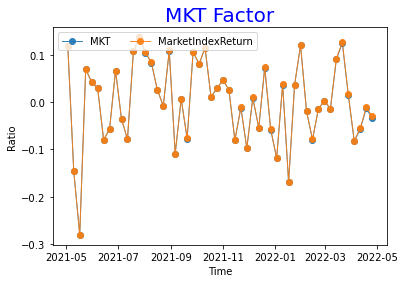

In [32]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

factors = marketport[["Date", "MKT","MarketIndexReturn"]]

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o', linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("MKT Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()

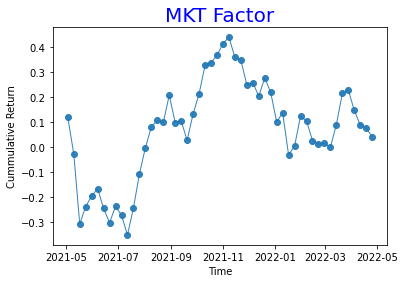

In [31]:
plt.plot(MKT_f.Date, np.cumsum(MKT_f.MKT), marker='o', linewidth=1, alpha=0.9, label=column)
plt.title("MKT Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative Return")
plt.show()

## 3. SMB Factor (Fiona)

### 3.1 Using quantile method to get the dynamic portfolios for top cap 20%, and bottom cap 20% 

In [33]:
largeCap = largeCapSample.groupby(['Date']).apply(lambda 
                                                x: x.nlargest(round(0.2*len(x)),
                                                              ['MarketCap'])).reset_index(drop=True)

smallCap = largeCapSample.groupby(['Date']).apply(lambda 
                                                x: x.nsmallest(round(0.2*len(x)),
                                                              ['MarketCap'])).reset_index(drop=True)
largeCap.head()

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset,Return,week2_return,Npast52_return,ExcessReturn
0,2021-05-03,58218.566077,1.088991e+12,6622607.0,0.0001,BTC,0.028357,0.187168,5.020518,0.028257
1,2021-05-03,3932.359246,4.554030e+11,3548128.0,0.0001,ETH,0.331870,0.699593,17.982967,0.331770
2,2021-05-03,1.000026,5.372178e+10,576798.0,0.0001,USDT,0.000035,0.000057,-0.002087,-0.000065
3,2021-05-03,385.704466,2.608153e+10,1438322.0,0.0001,LTC,0.433524,0.722933,7.838155,0.433424
4,2021-05-03,52.096533,2.182895e+10,65705.0,0.0001,LINK,0.320233,0.652190,12.766384,0.320133


### 3.2 Using equal-weighted average method to get the SMB
SMB = equal-weighted average of returns on small portfolis - equal-weighted average of returns on large portfolis

In [36]:
largeport = largeCap.groupby('Date')['Return'].mean().reset_index(name='LargePortReturn')
smallport = smallCap.groupby('Date')['Return'].mean().reset_index(name='SmallPortReturn')
smallport['SMB'] = smallport['SmallPortReturn'] - largeport['LargePortReturn']
SMB_f = smallport[['Date','SMB']]

In [37]:
SMB_f.head()

,Date,SMB
0,2021-05-03,-0.143667
1,2021-05-10,-0.189053
2,2021-05-17,-0.148497
3,2021-05-24,0.004411
4,2021-05-31,0.029201


### <font color = 'green'> Test SMB

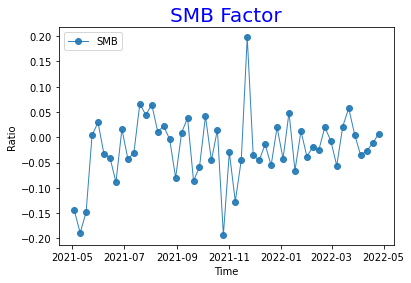

In [39]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

factors = SMB_f

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o', linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("SMB Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()

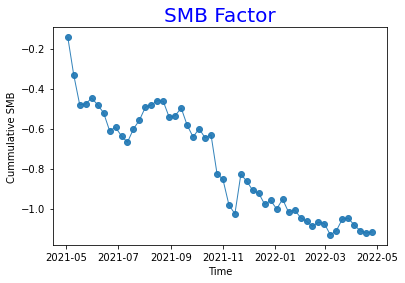

In [42]:
plt.plot(SMB_f.Date, np.cumsum(SMB_f.SMB), marker='o', linewidth=1, alpha=0.9, label=column)
plt.title("SMB Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative SMB")
plt.show()

In [43]:
from sklearn.linear_model import LinearRegression
performance = {}


factors = SMB_f

features = factors.columns.tolist()
features.remove('Date')
target = "ExcessReturn"

for index in fullSample['Asset'].unique().tolist():
    syntax = f"Asset == '{index}'"
    segment = fullSample.query(syntax)
    
    reg = segment[['Date','ExcessReturn']].merge(factors, on = 'Date', how = 'outer')
    y = reg [target].copy()
    x = reg [features].copy()    
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)    
    alpha = model.intercept_    
    performance[index] = alpha

In [44]:
alp_sig = pd.DataFrame(list(performance.items()), 
                       columns = ['Asset','Alpha'])
alp_sig = alp_sig.sort_values(by=['Alpha'], 
                              ascending = False)
alp_sig.head(10)

,Asset,Alpha
15,BRD,0.195732
112,VERI,0.083878
71,NFTX,0.082342
5,AMPL,0.064211
54,LDO,0.053610
68,MX,0.044315
28,DDX,0.041852
58,LRC,0.041307
87,QNT,0.040772
93,RPL,0.039205


In [45]:
alp_sig.tail(10)

,Asset,Alpha
32,DMG,-0.014985
14,BOND,-0.015631
63,MIR,-0.018728
118,YAM,-0.020562
31,DHT,-0.021591
34,DOUGH,-0.021652
52,LAMB,-0.022139
20,CND,-0.024242
73,Nsure,-0.026052
7,ARMOR,-0.037581


In [46]:
al = alp_sig.head(10).Asset.tolist()
hi = fullSample.query("Asset in @al ")

mk = hi.groupby('Asset')['MarketCap'].mean().reset_index(name = "AverageMarketCap")
mk

,Asset,AverageMarketCap
0,AMPL,1.445432e+08
1,BRD,2.657980e+07
2,DDX,1.063225e+08
3,LDO,1.300025e+08
4,LRC,1.195700e+09
5,MX,2.055389e+08
6,NFTX,5.288922e+07
7,QNT,1.950075e+09
8,RPL,2.945992e+08
9,VERI,1.018901e+08


In [47]:
asm = alp_sig.tail(10).Asset.tolist()
lo = fullSample.query("Asset in @asm ")

ml = lo.groupby('Asset')['MarketCap'].mean().reset_index(name = "AverageMarketCap")
ml

,Asset,AverageMarketCap
0,ARMOR,1.743356e+07
1,BOND,3.827531e+09
2,CND,2.369338e+07
3,DHT,1.481919e+07
4,DMG,2.217906e+06
5,DOUGH,5.848372e+06
6,LAMB,2.159385e+07
7,MIR,2.226654e+08
8,Nsure,1.129428e+06
9,YAM,3.947659e+06


## 4. VAL Factor (Lydia)

**4.1 Reshape to get three tables with: Npast52_return, MarketCap, Return**

In [48]:
value_npast52 = fullSample.loc[:,['Date', 
                                  'Npast52_return', 
                                  'Asset']].pivot(index="Date", 
                                                  columns=["Asset"], 

                                                  values='Npast52_return').reset_index().rename_axis(None, 
                                                                                                     axis=1).sort_values('Date')
#value_npast52.to_csv('value_npast52.csv')
#value_npast52.head()

In [49]:
value_marketcap = fullSample.loc[:,['Date',
                                    'MarketCap',
                                    'Asset']].pivot(index ='Date', 
                                                    columns = ["Asset"],
                                                    values = 'MarketCap'). reset_index().rename_axis(None,
                                                                                                    axis=1).sort_values('Date')
#value_marketcap.head(3)

value_weekreturn = fullSample.loc[:, ['Date',
                                      'Return',
                                      'Asset']].pivot(index='Date',
                                                      columns=['Asset'],
                                                      values ='Return').reset_index().rename_axis(None,
                                                                                                  axis=1).sort_values('Date')
                                                                                   
#value_weekreturn.head(3)

**4.2 Generate two tables to identify whether in a day a coins is top20 or low20 against Npast52:**

In [50]:
value_npast52_temp = value_npast52.copy()
cols_coins = list(fullSample['Asset'].unique())

value_npast52_temp['top20'] = value_npast52[cols_coins].quantile(q=0.8, axis=1, numeric_only=True, interpolation='linear')
value_npast52_temp['low20'] = value_npast52[cols_coins].quantile(q=0.2, axis=1, numeric_only=True, interpolation='linear')

value_npast52_top = value_npast52_temp.drop(columns =['Date','low20'])
value_npast52_low = value_npast52_temp.drop(columns =['Date','top20'])

index_top = value_npast52_top.apply(lambda x: x > value_npast52_top.iloc[:,-1])
index_top = index_top.drop(columns='top20')
index_low = value_npast52_low.apply(lambda x: x < value_npast52_low.iloc[:,-1])
index_low = index_low.drop(columns='low20')
index_low.tail()

,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,BIX,...,VERI,WBTC,WETH,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM
47,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,False
48,False,False,False,False,True,False,False,True,False,True,...,False,False,False,False,True,True,False,False,False,False
49,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
50,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,False
51,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False


**4.3 Calculate top20 and low20 weighted weekly return:**

In [51]:
sum_top_weight = pd.DataFrame((value_weekreturn.iloc[:,1:].values 
                               * index_top.values 
                               * value_marketcap.iloc[:,1:].values))
sum_top_weight['weight_top_sum'] = sum_top_weight.sum(axis='columns')


sum_top_mktcap_temp = pd.DataFrame((index_top.values 
                               * value_marketcap.iloc[:,1:].values))
sum_top_weight['Totalmktcap_top'] = sum_top_mktcap_temp.sum(axis='columns')
sum_top_weight['ValFactor_top'] = sum_top_weight['weight_top_sum'] / sum_top_weight['Totalmktcap_top']

In [52]:
sum_low_weight = pd.DataFrame((value_weekreturn.iloc[:,1:].values 
                               * index_low.values 
                               * value_marketcap.iloc[:,1:].values))
sum_low_weight['weight_low_sum'] = sum_low_weight.sum(axis='columns')

sum_low_mktcap_temp = pd.DataFrame((index_low.values 
                               * value_marketcap.iloc[:,1:].values))
sum_low_weight['Totalmktcap_low'] = sum_low_mktcap_temp.sum(axis='columns')
sum_low_weight['ValFactor_low'] = sum_low_weight['weight_low_sum'] / sum_low_weight['Totalmktcap_low']

**4.4 Get Value Factor:**

In [53]:
valueFactor = pd.DataFrame(columns=['Date','VAL'])
valueFactor['Date'] = value_weekreturn['Date']
valueFactor['VAL'] = sum_top_weight['ValFactor_top'] - sum_low_weight['ValFactor_low']
valueFactor

,Date,VAL
0,2021-05-03,0.427391
1,2021-05-10,0.165418
2,2021-05-17,-0.409644
3,2021-05-24,0.149525
4,2021-05-31,0.121057
5,2021-06-07,-0.068965
6,2021-06-14,-0.099015
7,2021-06-21,-0.122532
8,2021-06-28,0.164612
9,2021-07-05,-0.073297


**4.5 Factor visualization:**

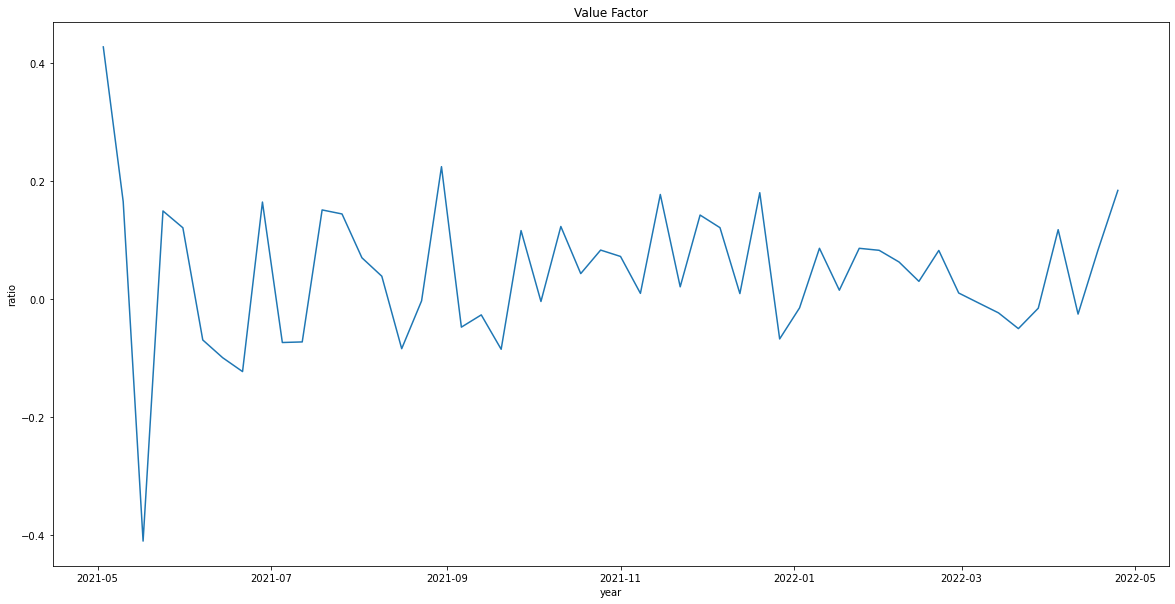

In [54]:
import matplotlib.pyplot as plt

#for i in regr_df.columns.to_list():
plt.figure(figsize = (20,10))
plt.plot(valueFactor.Date, valueFactor.VAL)
plt.ylabel('ratio')
plt.xlabel('year')
plt.title('Value Factor')
plt.show()


## 5. MOM Factor (Sean)

### Get LargeCap Sample(maket cap > 10000)

In [55]:
# Filter MarketCap to Get largeSample
largeCapSample = fullSample.query("MarketCap > 1000000")
largeCapSample

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset,Return,week2_return,Npast52_return,ExcessReturn
0,2021-05-03,58218.566077,1.088991e+12,6622607.0,0.0001,BTC,0.028357,0.187168,5.020518,0.028257
1,2021-05-10,46406.331544,8.683518e+11,6062366.0,0.0001,BTC,-0.202895,-0.180291,4.277670,-0.202995
2,2021-05-17,34888.678313,6.530094e+11,4960283.0,0.0001,BTC,-0.248191,-0.400729,2.690965,-0.248291
3,2021-05-24,35639.981455,6.672647e+11,4981835.0,0.0000,BTC,0.021534,-0.232002,2.651751,0.021534
4,2021-05-31,35797.422390,6.704378e+11,4893673.0,0.0001,BTC,0.004418,0.026047,2.813597,0.004318
...,...,...,...,...,...,...,...,...,...,...
6287,2022-03-28,0.910632,7.717570e+08,835.0,0.0017,ZRX,0.254326,0.654764,-0.574214,0.252626
6288,2022-04-04,0.754619,6.395366e+08,1284.0,0.0017,ZRX,-0.171324,0.039430,-0.567780,-0.173024
6289,2022-04-11,0.686854,5.821057e+08,1266.0,0.0020,ZRX,-0.089801,-0.245740,-0.487158,-0.091801
6290,2022-04-18,0.808817,6.854696e+08,2274.0,0.0031,ZRX,0.177569,0.071822,-0.567022,0.174469


### Reshape Dataframe

In [56]:
# Get Return DataFrame
returnAll = largeCapSample.loc[:, ['Date',
                                   'Return',
                                   'Asset']].pivot(index="Date",
                                                   columns=["Asset"],
                                                   values='Return').reset_index().rename_axis(None,
                                                                                              axis=1).sort_values('Date')
returnAll.head()

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,UTK,VERI,WBTC,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM
0,2021-05-03,-0.049263,0.022970,0.112456,0.069679,0.080898,-0.024938,0.079109,0.001570,0.126182,...,-0.003380,0.406858,0.032826,0.141704,0.070760,NaN,0.102180,0.046813,0.010270,0.348608
1,2021-05-10,0.143665,-0.171471,-0.281857,-0.244447,-0.323333,-0.256346,-0.182583,-0.204940,-0.194722,...,-0.254292,0.062182,-0.204564,-0.164128,-0.319218,NaN,0.234226,-0.195655,-0.007335,-0.150428
2,2021-05-17,-0.435925,-0.482439,-0.357192,-0.560776,-0.456955,-0.597872,-0.523110,-0.514725,-0.504094,...,-0.542375,-0.447383,-0.245743,-0.593304,-0.551696,NaN,-0.499353,-0.486727,-0.019204,-0.410748
3,2021-05-24,0.094413,0.379361,0.464830,0.228098,0.103387,0.117416,0.069808,0.085198,0.244939,...,0.164792,0.188722,0.019047,0.204790,0.212288,NaN,0.272157,0.161636,0.005509,0.241871
4,2021-05-31,0.126079,-0.039411,0.076882,0.345243,-0.040499,0.302944,0.054685,0.090265,0.082609,...,0.163088,0.046409,0.005559,-0.025069,0.090076,NaN,0.028074,0.128756,0.000937,0.052810


In [57]:
# Get Price DataFrame
capAll = largeCapSample.loc[:, ['Date',
                                'MarketCap',
                                'Asset']].pivot(index="Date",
                                                columns=["Asset"],
                                                values='MarketCap').reset_index().rename_axis(None,
                                                                                              axis=1).sort_values('Date')
capAll.head()

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,UTK,VERI,WBTC,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM
0,2021-05-03,5.735887e+09,2.256086e+07,2.526164e+08,2.017177e+08,5.443477e+07,3.027644e+08,4.597610e+08,3.617656e+08,2.111519e+09,...,3.318752e+08,5.324600e+07,9.906188e+09,1.416346e+08,5.975726e+07,NaN,1.951897e+09,1.528303e+09,1.462172e+08,1.973831e+08
1,2021-05-10,6.648981e+09,1.869232e+07,1.814148e+08,1.524085e+08,4.557013e+07,2.295646e+08,3.758166e+08,2.876253e+08,1.702456e+09,...,2.474819e+08,5.655696e+07,8.084615e+09,1.183883e+08,4.068168e+07,NaN,2.409084e+09,1.286737e+09,1.451447e+08,1.676911e+08
2,2021-05-17,3.779533e+09,9.674406e+06,1.599928e+08,6.694150e+07,3.158087e+07,9.413106e+07,1.792233e+08,1.395775e+08,8.449776e+08,...,1.132538e+08,3.125433e+07,6.288841e+09,4.814811e+07,1.823774e+07,NaN,1.206103e+09,6.795007e+08,2.038237e+08,9.881228e+07
3,2021-05-24,4.141262e+09,1.334450e+07,1.904880e+08,8.221074e+07,3.862744e+07,1.081680e+08,1.917345e+08,1.514692e+08,1.051984e+09,...,1.319171e+08,3.715271e+07,6.548297e+09,5.800838e+07,2.210939e+07,NaN,1.534352e+09,7.894613e+08,2.515073e+08,1.227121e+08
4,2021-05-31,4.669538e+09,1.281857e+07,1.763299e+08,1.133197e+08,3.765641e+07,1.452830e+08,2.022194e+08,1.651416e+08,1.139018e+09,...,1.534312e+08,3.887694e+07,6.682725e+09,5.966491e+07,2.410091e+07,NaN,1.577431e+09,8.912247e+08,2.567663e+08,1.291925e+08


### Calculate Momentum Matrix(Cumulative 2 week Return)

In [58]:
def getMomMatrix(largeCapSample: pd.DataFrame):
    """This Method Transform LargeCap Matrix to MOM Matrix

    Args:
        largeCapSample (pd.DataFrame): largeCap Matrix Should Contain Every Coins' Full Data

    Returns:
        momMatrix (pd.DataFrame): The Method Returns a MomMatrix
    """
    momMatrix = largeCapSample.loc[:, ['Date',
                                       'week2_return',
                                       'Asset']].pivot(index="Date",
                                                       columns=["Asset"],
                                                       values='week2_return').reset_index().rename_axis(None,
                                                                                                        axis=1).sort_values('Date')
    return momMatrix

# Effect:
momMatrix = getMomMatrix(largeCapSample)
momMatrix.head()

,Date,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,...,UTK,VERI,WBTC,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM
0,2021-05-03,0.324384,0.175152,0.030589,0.304105,0.111860,0.414658,0.383932,0.309461,0.384131,...,0.944423,0.340565,0.187350,0.514041,0.650508,NaN,0.338622,0.460070,0.006242,0.606434
1,2021-05-10,0.087325,-0.152440,-0.201097,-0.191801,-0.268592,-0.274891,-0.117918,-0.203692,-0.093110,...,-0.256813,0.494340,-0.178453,-0.045682,-0.271046,NaN,0.360338,-0.158000,0.002860,0.145739
2,2021-05-17,-0.354887,-0.571186,-0.538372,-0.668143,-0.632540,-0.700956,-0.610182,-0.614177,-0.600658,...,-0.658746,-0.413020,-0.400037,-0.660054,-0.694803,NaN,-0.382088,-0.587151,-0.026398,-0.499388
3,2021-05-24,-0.382668,-0.286097,-0.058396,-0.460589,-0.400811,-0.550656,-0.489819,-0.473380,-0.382628,...,-0.466963,-0.343092,-0.231377,-0.510016,-0.456527,NaN,-0.363098,-0.403763,-0.013801,-0.268225
4,2021-05-31,0.232395,0.324998,0.577449,0.652091,0.058700,0.455930,0.128310,0.183153,0.347782,...,0.354755,0.243890,0.024712,0.174587,0.321486,NaN,0.307871,0.311204,0.006451,0.307454


### Calculate MOM Percentile(20%, 80%)

In [59]:
def getMomPt(momMatrix: pd.DataFrame):
    """This Method Calculate 20% and 80% Percentile of MomMatrix

    Args:
        momMatrix (pd.DataFrame): MomMatrix Should Contain All Coins' 2-Week Cumulative Returns

    Returns:
        momPt (pd.DataFrame): momPt Has 3 Columns: Date, MOM30p and MOM70p
    """

    # Only Select Assets(BTC, ETH...) Columns
    col = []
    for colName in momMatrix.columns:
        if colName not in ['Date']:
            col.append(colName)
    momMatrix[col].head()

    momPt = pd.DataFrame(columns=['MOM20p',
                                  'MOM80p'])

    momPt['MOM20p'] = momMatrix[col].quantile(.2, axis=1)
    momPt['MOM80p'] = momMatrix[col].quantile(.8, axis=1)

    return momPt

In [60]:
momPt = getMomPt(momMatrix)
momPt.head()

,MOM20p,MOM80p
0,0.105609,0.508565
1,-0.252592,0.042379
2,-0.628842,-0.400133
3,-0.459777,-0.243871
4,0.074682,0.387382


### Calculate Momentum portfolio returns

In [61]:
def LMH_MOM(momMatrix: pd.DataFrame,
            returnAll: pd.DataFrame,
            capAll: pd.DataFrame,
            momPt: pd.DataFrame):
    """This Method Takes MomMatrix, ReturnMatrix, CapMatrix and MomPercentileMatrix to Get Low, Medium and High Momentum\nWARNING: These 4 Matrix MUST be in Exactly the Same Shape!

    Args:
        momMatrix (pd.DataFrame): MomMatrix Should Contain All Coins' 2-Week Cumulative Returns
        returnAll (pd.DataFrame): Return Matrix Should Contain Every Coins' Return Data
        capAll (pd.DataFrame):  Captial Matrix Should Contain Every Coins' MarketCap Data
        momPt (pd.DataFrame): Mom Percentile Matrix Should Contain 30 & 70 Percentile Momentum

    Returns:
        momLMH (pd.DataFrame): A DataFrame Contains Date, LowMomentum, MediumMomentum and HighMomentum Returns
    """
    # Initialize DataFrames for Low, Medium and High MOM
    lowMom = pd.DataFrame(columns=['Date',
                                   'LowMomentum'])
    lowMom['Date'] = momMatrix['Date']

    medMom = pd.DataFrame(columns=['Date',
                                   'MedMomentum'])
    medMom['Date'] = momMatrix['Date']

    highMom = pd.DataFrame(columns=['Date',
                                    'HighMomentum'])
    highMom['Date'] = momMatrix['Date']

    print("\nCalculating Low, Medium and High Momentum Matrix...")

    # Iterate Through Whole DataFrame to Get Low, Medium and High MOM
    # Iterate Though Rows
    for i in tqdm(range(0, momMatrix.shape[0])):

        # Initialization df Used in Method
        lowMomReturnList = []
        medMomReturnList = []
        highMomReturnList = []

        lowMomCapList = []
        medMomCapList = []
        highMomCapList = []

        # Iterate Through Columns
        for j in range(1, momMatrix.shape[1]):
            if momMatrix.iloc[i, j] < momPt.iloc[i, 0]:
                lowMomReturnList.append(returnAll.iloc[i, j])
                lowMomCapList.append(capAll.iloc[i, j])
            elif (momPt.iloc[i, 0] < momMatrix.iloc[i, j]) and (momMatrix.iloc[i, j] < momPt.iloc[i, 1]):
                medMomReturnList.append(returnAll.iloc[i, j])
                medMomCapList.append(capAll.iloc[i, j])
            elif momMatrix.iloc[i, j] > momPt.iloc[i, 1]:
                highMomReturnList.append(returnAll.iloc[i, j])
                highMomCapList.append(capAll.iloc[i, j])

        # Low MOM
        lowValueWeightedAvgList = []
        lowMomCapSum = sum(lowMomCapList)
        for index in range(0, len(lowMomCapList)):
            lowValueWeightedAvgList.append(
                (lowMomCapList[index]/lowMomCapSum) * lowMomReturnList[index]
                )
        lowMom.iloc[i, 1] = sum(lowValueWeightedAvgList)

        # Med MOM
        medValueWeightedAvgList = []
        medMomCapSum = sum(medMomCapList)
        for index in range(0, len(medMomCapList)):
            medValueWeightedAvgList.append(
                (medMomCapList[index]/medMomCapSum) * medMomReturnList[index]
                )
        medMom.iloc[i, 1] = sum(medValueWeightedAvgList)

        # High MOM
        highValueWeightedAvgList = []
        highMomCapSum = sum(highMomCapList)
        for index in range(0, len(highMomCapList)):
            highValueWeightedAvgList.append(
                (highMomCapList[index]/highMomCapSum) * highMomReturnList[index]
                )
        highMom.iloc[i, 1] = sum(highValueWeightedAvgList)

        # Merge
        from functools import reduce
        momLMH = reduce(lambda left, right:
                        pd.merge(left, right,
                                 on='Date',
                                 how='outer'),
                        [lowMom, medMom, highMom])

    return momLMH

momLMH = LMH_MOM(momMatrix, returnAll, capAll, momPt)


Calculating Low, Medium and High Momentum Matrix...


100%|███████████████████████████████████████████| 52/52 [00:01<00:00, 28.96it/s]


In [62]:
momLMH.head()

,Date,LowMomentum,MedMomentum,HighMomentum
0,2021-05-03,-0.002751,0.027602,0.345279
1,2021-05-10,-0.16583,-0.181812,-0.067313
2,2021-05-17,-0.556303,-0.304205,-0.068091
3,2021-05-24,0.133358,0.155542,0.029855
4,2021-05-31,0.004335,0.122936,0.00366


### Calculate Momentum Factor

In [63]:
def getMomFactor(momLMH: pd.DataFrame):
    """This Method Takes momLMH Matrix to Calculate Momentum Factor

    Args:
        momLMH (pd.DataFrame): Mom LMH Matrix Should Contain Low, Medium, and High Momentum Returns

    Returns:
        momFactor (pd.DataFrame): A DataFrame Contains a Date Column and a Momentum Factor Column
    """
    momFactor = pd.DataFrame(columns=['Date', 'MOM_LTW'])
    momFactor['Date'] = momLMH['Date']
    momFactor['MOM_LTW'] = momLMH['HighMomentum'] - momLMH['LowMomentum']
    return momFactor

In [71]:
momFactor = getMomFactor(momLMH)
momFactor.head()

,Date,MOM_LTW
0,2021-05-03,0.34803
1,2021-05-10,0.098517
2,2021-05-17,0.488212
3,2021-05-24,-0.103503
4,2021-05-31,-0.000675


## 6. NET Factor (Zachary)

The network factor (NET) is constructed by splitting the coins of the Core Sample into 3 groups due to the limitation of available coins. Particularly, each week we split the cryptocurrencies into three [30% 40% 30%] groups by the growth rate in total addresses with balance. The network factor (NET) is the return difference between the top and the bottom network portfolios. 

### Get Address Growth

In [64]:
Address = fullSample.loc[:,['Date', 'ActiveAddress', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'ActiveAddress')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

copy1 = Address.copy()
copy2 = copy1.shift()

Growth = copy1.copy()
for i in fullSample.Asset.unique():
    Growth[i] = np.log(copy1[i]) - np.log(copy2[i])

Growth['30Percentile'] = Growth.quantile(q=0.3, numeric_only = True, axis = 1)
Growth['70Percentile'] = Growth.quantile(q=0.3, numeric_only = True, axis = 1)

/Users/fionafu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Construct Network factor

In [65]:
Return = fullSample.loc[:,['Date', 'Return', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'Return')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

Marketcap = fullSample.loc[:,['Date', 'MarketCap', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'MarketCap')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

weight = Marketcap.copy()
weight['total_weight'] = Marketcap.sum(axis = 1, numeric_only=True)
weight[fullSample.Asset.unique()] = weight[fullSample.Asset.unique()].apply(lambda x: x/weight['total_weight'])
weight.drop(columns=['total_weight'])

Weighted_Return = Return.copy()
for i in fullSample.Asset.unique():
    Weighted_Return[i] = weight[i] * Return[i]

In [66]:
Return = fullSample.loc[:,['Date', 'Return', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'Return')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

NET = pd.DataFrame({'Date':[]})
NET['Date'] = Return.Date
NET['long'] = Return[Growth[fullSample.Asset.unique()].apply(lambda x: x >= Growth['70Percentile'])].mean(axis=1, numeric_only= True)
NET['short'] = Return[Growth[fullSample.Asset.unique()].apply(lambda x: x <= Growth['30Percentile'])].mean(axis=1, numeric_only= True)
NET.fillna(value = 0, inplace=True)
NET['NET'] = NET.long - NET.short
NET.drop(columns=['short', 'long'], inplace=True)

### Verification

Text(0, 0.5, 'Cumulative Return')

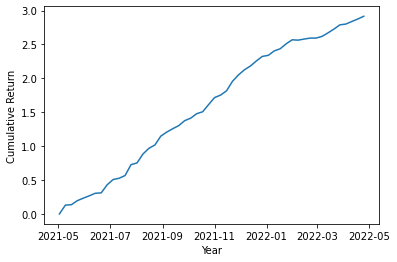

In [67]:
import matplotlib.pyplot as plt

plt.plot(NET.Date, np.cumsum(NET.NET))
plt.xlabel('Year')
plt.ylabel('Cumulative Return')

## 7.Regression Output
### 7.1 Output a list of alphas for all the crypto currencies using factors
Note: Only pick the top 100 cypto currencies from the latest week and check their alphas.

In [96]:
from sklearn.linear_model import LinearRegression

performance = {}

## find the top 100 cypto currencies at the last week

latest = largeCapSample.Date.max()
latestLarge = largeCapSample.query("Date == @latest")

# factors = factors.merge(MOM_f, on = 'Date', how ='outer')
factors = MKT_f.merge(SMB_f, on = 'Date', how = 'outer')

# VAL Added
factors = factors.merge(valueFactor, on = 'Date', how = 'outer')

# MOM Added
factors = factors.merge(momFactor, on = 'Date', how ='outer')

# NET added
factors = factors.merge(NET, on = 'Date', how ='outer')

features = factors.columns.tolist()
features.remove('Date')
target = "ExcessReturn"

for index in latestLarge['Asset'].tolist():
    syntax = f"Asset == '{index}'"
    segment = fullSample.query(syntax)
    
    reg = segment[['Date','ExcessReturn']].merge(factors, on = 'Date', how = 'outer')
    y = reg [target].copy()
    x = reg [features].copy()    
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)    
    alpha = model.intercept_    
    performance[index] = alpha

In [97]:
factors

,Date,MKT,SMB,VAL,MOM_LTW,NET
0,2021-05-03,0.118404,-0.143667,0.427391,0.34803,0.000000
1,2021-05-10,-0.145781,-0.189053,0.165418,0.098517,0.129719
2,2021-05-17,-0.280499,-0.148497,-0.409644,0.488212,0.006300
3,2021-05-24,0.069525,0.004411,0.149525,-0.103503,0.059452
4,2021-05-31,0.042021,0.029201,0.121057,-0.000675,0.036665
5,2021-06-07,0.029528,-0.033515,-0.068965,0.216259,0.034761
6,2021-06-14,-0.079382,-0.040202,-0.099015,0.067207,0.037378
7,2021-06-21,-0.057400,-0.088904,-0.122532,0.212212,0.005960
8,2021-06-28,0.066367,0.016105,0.164612,0.332424,0.119494
9,2021-07-05,-0.036054,-0.042806,-0.073297,0.219559,0.077866


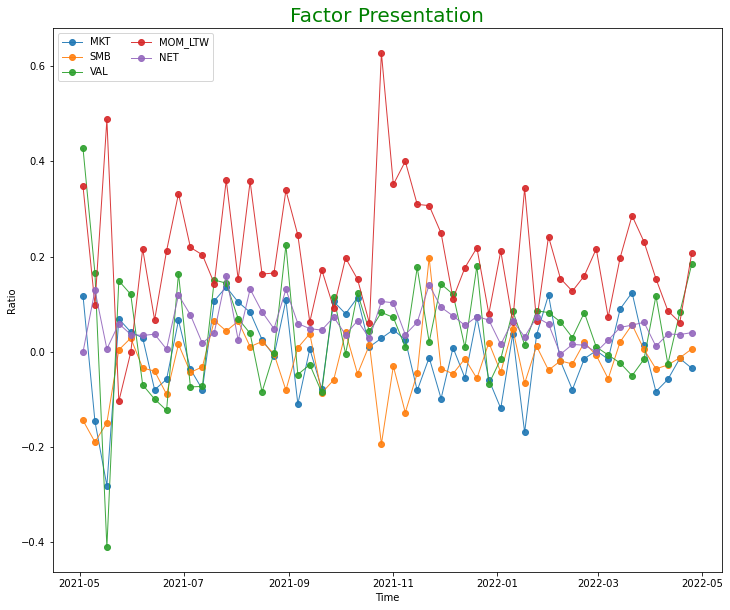

In [101]:
from matplotlib.pyplot import figure

plt.figure(figsize=(12,10))

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o',  linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("Factor Presentation", loc='center', fontsize=20, fontweight=0, color='green')
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()

### 7.2 Currently using values (not abs value) of alpha to sort all the crypto currencies

In [102]:
alp_sig = pd.DataFrame(list(performance.items()), 
                       columns = ['Asset','Alpha'])
alp_sig = alp_sig.sort_values(by=['Alpha'], 
                              ascending = False)
alp_sig.head(10)

,Asset,Alpha
72,AMPL,0.173504
90,CREAM,0.113653
70,VERI,0.108259
67,MLN,0.096935
92,SAN,0.094785
46,TEL,0.061397
93,DRGN,0.055138
69,BADGER,0.051611
21,OKB,0.048632
19,NEXO,0.042010
